# LSTM Model

This notebook is used to develop an LSTM model for predicting Dow Jones stocks.  

We will begin with the Walmart stock data as a beginning test.

### Packages

First, we load important packages.

In [1]:
#import some useful packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Data

Now, we can load the data.

In [2]:
#load Walmart Stock Data
filepath = os.path.join('..', 'Resources', 'WMT.csv')
df = pd.read_csv(filepath)
df.head()

,date,open,high,low,close,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2014-01-27,64.7650,64.9747,64.5029,64.7825,9105139,9105139,-0.235889,-0.363,64.7739,"Jan 27, 14",0.000000
1,2014-01-28,64.8786,65.8746,64.7388,65.2368,6035231,6035231,0.454305,0.701,65.3045,"Jan 28, 14",0.007013
2,2014-01-29,65.7785,65.8484,64.7126,64.7388,8440854,8440854,-0.497990,-0.763,61.0517,"Jan 29, 14",-0.000675
3,2014-01-30,65.1232,65.6037,64.9660,65.3067,6742046,6742046,0.567883,0.877,65.2975,"Jan 30, 14",0.008092
4,2014-01-31,64.5816,65.6911,64.3369,65.2455,10665285,10665285,-0.061155,-0.094,65.3223,"Jan 31, 14",0.007147


We get rid of columns we do not need and set the index as the date column.

In [3]:
#drop unnessecary columns
df.drop(['volume', 'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label', 'changeOverTime'], 1, inplace = True)
df.head()

,date,open,high,low,close
0,2014-01-27,64.7650,64.9747,64.5029,64.7825
1,2014-01-28,64.8786,65.8746,64.7388,65.2368
2,2014-01-29,65.7785,65.8484,64.7126,64.7388
3,2014-01-30,65.1232,65.6037,64.9660,65.3067
4,2014-01-31,64.5816,65.6911,64.3369,65.2455


In [4]:
#set index
df.set_index('date', inplace = True)
df.head()

,open,high,low,close
date,,,,
2014-01-27,64.7650,64.9747,64.5029,64.7825
2014-01-28,64.8786,65.8746,64.7388,65.2368
2014-01-29,65.7785,65.8484,64.7126,64.7388
2014-01-30,65.1232,65.6037,64.9660,65.3067
2014-01-31,64.5816,65.6911,64.3369,65.2455


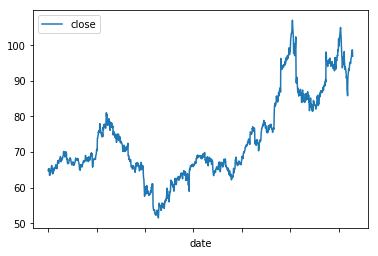

In [6]:
#plot close price
df.plot(y='close')

### Create Train and Test Split Data

We need to create a train/test split.  To do so, we will assume we feed sequences of some length and predict at some point in the future.

In [13]:
#save data as a matrix
data = df.values
data.shape

(1259, 4)

In [23]:
#save sequence length and time in the future
#we will start with 30 days and 5 days in the future (about 1 month and 1 week)
seq_length = 30
fut_point = 5
features = 4

In [16]:
#get X data (30 day sequences)
X = []
#get all sequences up to (sequence length + future point) days out of last point (can then predict last point)
for index in range(len(data) - seq_length - fut_point):
    X.append(data[index: index + seq_length])
#get X as a numpy array
X = np.array(X)
X.shape

(1224, 30, 4)

In [18]:
#get Y data (close price for all days except first (sequence length + future point) days)
y = data[(seq_length + fut_point):, -1]
y.shape

(1224,)

In [20]:
#train/test split of 0.85/0.15
train_split = 0.85
last_row = int(train_split * X.shape[0])
X_train = X[:last_row]
X_test = X[last_row:]
y_train = y[:last_row]
y_test = y[last_row:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1040, 30, 4)
(184, 30, 4)
(1040,)
(184,)


### Scale Data
We scale the data using the MinMaxScaler fit for the training data.

In [21]:
#instantiate scalers
X_scaler = MinMaxScaler(feature_range = (-1, 1))
y_scaler = MinMaxScaler(feature_range = (-1, 1))

In [29]:
#reshape data so it can be fit
X_train_reshaped = np.reshape(X_train, (-1, 4))
X_test_reshaped = np.reshape(X_test, (-1, 4))
y_train_reshaped = np.reshape(y_train, (-1, 1))
y_test_reshaped = np.reshape(y_test, (-1, 1))

In [31]:
#fit scalers
X_scaler.fit(X_train_reshaped)
y_scaler.fit(y_train_reshaped)

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [32]:
#transform and rescale
X_train_scaled = np.reshape(X_scaler.transform(X_train_reshaped), X_train.shape)
X_test_scaled = np.reshape(X_scaler.transform(X_test_reshaped), X_test.shape)
y_train_scaled = np.reshape(y_scaler.transform(y_train_reshaped), y_train.shape[0])
y_test_scaled = np.reshape(y_scaler.transform(y_test_reshaped), y_test.shape[0])
X_train_scaled.shape

(1040, 30, 4)

### LSTM model
Now, we build a basic LSTM network model.

We build several LSTM layers together, adding Dropout layers and a few dense layers to summarize.

In [33]:
#import layers
from keras.models import Sequential, load_model
from keras.layers. import Dense, Dropout, LSTM

/anaconda3/envs/PythonData/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [37]:
#create an LSTM model
model = Sequential()

#add first LSTM layer and dropout layer
model.add(LSTM(256, return_sequences = True, input_shape = (seq_length, features)))
model.add(Dropout(0.2))

#add second LSTM layer and dropout layer
model.add(LSTM(256, return_sequences = False))
model.add(Dropout(0.2))

#add an reLU layer
model.add(Dense(32, activation = 'relu'))

#add a final layer
model.add(Dense(1, activation = 'linear'))

#compile model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 256)           267264    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 800,833
Trainable params: 800,833
Non-trainable params: 0
_________________________________________________________________


In [38]:
#fit model
model.fit(X_train_scaled, y_train_scaled, epochs = 300, batch_size = 64, validation_split = 0.15, verbose = 1)

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 3s 4ms/step - loss: 0.0414 - acc: 0.0011 - val_loss: 0.0694 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0087 - acc: 0.0011 - val_loss: 0.0662 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.0693 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.0780 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.0854 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0055 - acc: 0.0011 - val_loss: 0.0931 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1094 - val_acc: 0.0000

884/884 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.3284 - val_acc: 0.0000e+00
Epoch 61/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.3033 - val_acc: 0.0000e+00
Epoch 62/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.2847 - val_acc: 0.0000e+00
Epoch 63/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2807 - val_acc: 0.0000e+00
Epoch 64/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2751 - val_acc: 0.0000e+00
Epoch 65/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.2864 - val_acc: 0.0000e+00
Epoch 66/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2895 - val_acc: 0.0000e+00
Epoch 67/300
884/884 [=========================

884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1052 - val_acc: 0.0064
Epoch 120/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0901 - val_acc: 0.0064
Epoch 121/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0713 - val_acc: 0.0064
Epoch 122/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0649 - val_acc: 0.0064
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0667 - val_acc: 0.0064
Epoch 124/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.1345 - val_acc: 0.0064
Epoch 125/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0939 - val_acc: 0.0064
Epoch 126/300
884/884 [==============================] - 2s 2ms/step 

Epoch 180/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0740 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0413 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0570 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0992 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0476 - val_acc: 0.0064
Epoch 185/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0413 - val_acc: 0.0064
Epoch 186/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 187/300
884/884 [============================

884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0432 - val_acc: 0.0064
Epoch 241/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0682 - val_acc: 0.0064
Epoch 242/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0368 - val_acc: 0.0064
Epoch 243/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.0744 - val_acc: 0.0064
Epoch 244/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0589 - val_acc: 0.0064
Epoch 245/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.1166 - val_acc: 0.0064
Epoch 246/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0598 - val_acc: 0.0064
Epoch 247/300
884/884 [==============================] - 2s 2ms/step 

884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1371 - val_acc: 0.0064


In [39]:
model.save('first_model.h5')